AULA 06 - 11/09/2024

In [71]:
#Bibliotecas

import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from scipy.stats import pearsonr
from sklearn import linear_model
from scipy import stats
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.metrics import (roc_auc_score, roc_curve, classification_report,
                            accuracy_score, confusion_matrix, auc)

Lendo a base

In [72]:
df = pd.read_csv('tratores.csv', delimiter=',', decimal='.')

Visualisando a base

In [73]:
df.head()

consumidor  rendimento  tamanho.lote  criacao.gado
0           0        33.0          18.8             1
1           0        43.2          20.4             1
2           0        47.4          16.4             1
3           0        49.2          17.6             0
4           1        51.0          22.0             1

Removendo espaços em branco no nome das colunas

In [74]:
df.columns = df.columns.str.strip()

Plotando gráfico de dispersão entre as variáveis de interesse

<Axes: xlabel='tamanho.lote', ylabel='consumidor'>

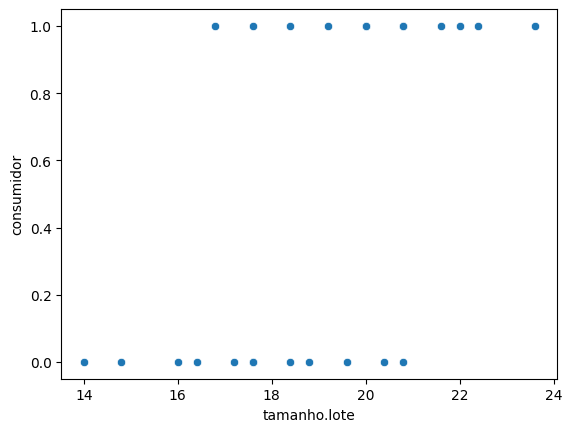

In [76]:
sbn.scatterplot(x = 'tamanho.lote', y = 'consumidor', data = df)

In [77]:
df.columns

Index(['consumidor', 'rendimento', 'tamanho.lote', 'criacao.gado'], dtype='object')

Vendo o tamnho do lote vs consumidor

<Axes: xlabel='consumidor', ylabel='tamanho.lote'>

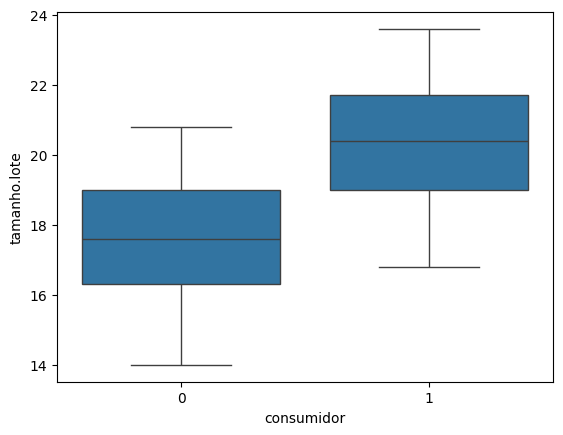

In [79]:
sbn.boxplot(y = 'tamanho.lote', x = 'consumidor', data = df)

<Axes: xlabel='consumidor', ylabel='rendimento'>

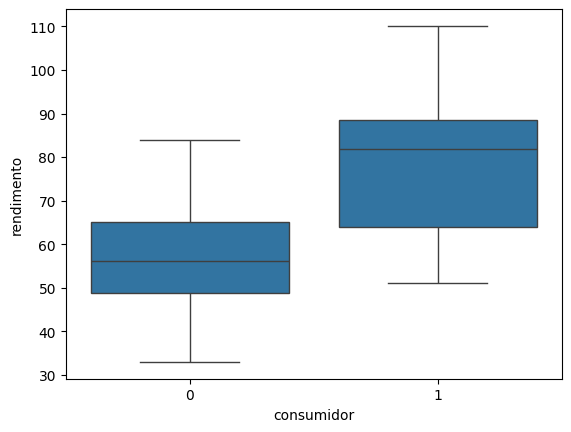

In [80]:
sbn.boxplot(y = 'rendimento', x = 'consumidor', data = df)

**Modelo de Regressão Logística**

In [11]:
# Separar variável resposta de explicativas

y = df['consumidor']
X = df[['rendimento', 'tamanho.lote', 'criacao.gado']]

**Construindo o modelo**

In [13]:
# é necessário adicionar uma constante a matriz X
X_sm = sm.add_constant(X)

# GLM vem de Generalized Linear Models e o método fit irá treinar o modelo
modelo = sm.GLM(y, X_sm, family = sm.families.Binomial()).fit()

# mostrando as estatísticas do modelo
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             consumidor   No. Observations:                   24
Model:                            GLM   Df Residuals:                       20
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6.8232
Date:                Wed, 11 Sep 2024   Deviance:                       13.646
Time:                        16:53:31   Pearson chi2:                     17.5
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5586
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -30.0278     13.463     -2.230      0.026     -56.415      -3.641
rendimento       0.1299      0.059      2.188      0.029       0.014       0.246
tamanho.lote     1.0759      0.535      2.012      0.044       0.028       2.124
criacao.gado     1.9432      1.645      1.181      0.238      -1.282       5.168
================================================================================
"""

**Calculando os ODDs Ratio**

In [22]:
print(np.exp(modelo.params[1:]))

rendimento      1.138762
tamanho.lote    2.932713
criacao.gado    6.981067
dtype: float64


# **Fitando os valores do modelo**

Perceba que o modelo solta uma probabilidade e não uma classificação

In [94]:
score_predito = modelo.fittedvalues   ## Calculando diretamente da base de treino

In [95]:
score_predito2 = modelo.predict(X_sm)  ## Calculando de uma base qualquer

# **Curva Roc e ponto de corte**

Função para plotar a curva RoC

In [88]:
def plot_roc_curve(y_true, y_score, figsize=(10,6)):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=figsize)
    auc_value = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, color='orange', label='(AUC = %0.2f)' % auc_value)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('1 - Sp')
    plt.ylabel('Se')
    plt.title('Curva RoC')
    plt.legend()
    plt.show()

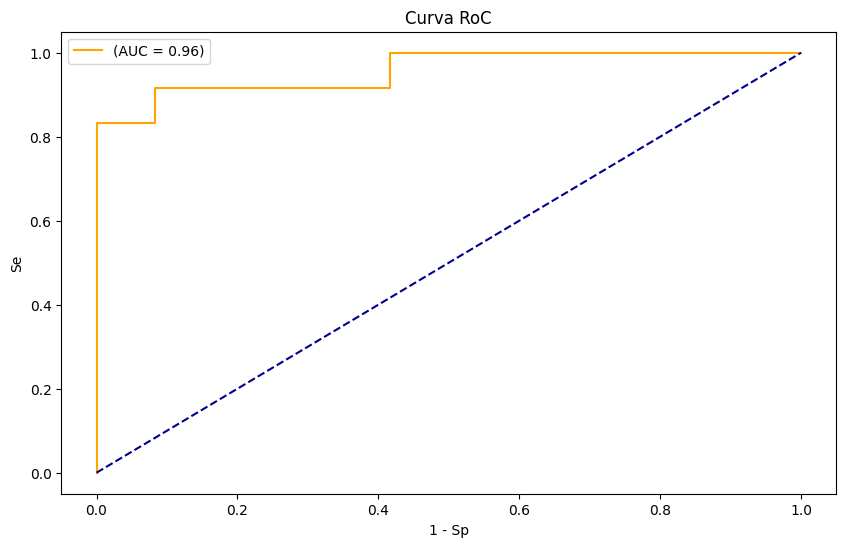

In [96]:
plot_roc_curve(y, score_predito)    #Plotando a curva

**Cálculo da AUC**

In [97]:
print('AUC: %0.2f' % roc_auc_score(y, score_predito))  #Exibindo o AUC

AUC: 0.96


**Achando o Ponto de Corte pelo método Youden**

In [98]:
fpr, tpr, thresholds = roc_curve(y, score_predito) # Pegando os valores de Se e Sp
idx = np.argmax(tpr - fpr)         # Maximizando a soma de Se e Sp
thresholds[idx]                    # Obtendo o ponto de Corte Ótimo


0.7504460130282516

**Classificando o modelo de acordo com o Ponto de Corte por Youden**

In [99]:
df['score'] =  score_predito
df['y_pred'] = np.where(df['score'] >= thresholds[idx], 1, 0)

**Classificando o modelo de acordo com o Ponto de Corte 0.5**

In [100]:
df['y_pred2'] = np.where(df['score'] >= 0.5, 1, 0)

**Matrix de confusão para a Predição Youden**

In [102]:
confusion_matrix(y, df['y_pred'])

array([[12,  0],
       [ 2, 10]])

**Acurácia para o méotodo Youden**

In [103]:
acuracia = accuracy_score(y, df['y_pred'])
print('O modelo obteve %0.4f de acurácia.' % acuracia)

O modelo obteve 0.9167 de acurácia.


**Fazendo um modelo alternativo usando o método de Seleção StepWise**

In [106]:
# Perform stepwise regression
sfs = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                k_features=2,   #Escolhendo 2 variáveis
                                forward=True,   #Método forward
                                scoring='accuracy',
                                cv=None)
selected_features = sfs.fit(X_sm, y)

selected_features.k_feature_names_  #Exibindo as variáveis selecionadas

('rendimento', 'tamanho.lote')

**Usando as variáveis selecionadas**

In [107]:
# Separar variável resposta de explicativas

y = df['consumidor']
X = df[['rendimento', 'tamanho.lote']]

**Construindo um novo modelo**

In [108]:
# é necessário adicionar uma constante a matriz X
X_sm = sm.add_constant(X)

# GLM vem de Generalized Linear Models e o método fit irá treinar o modelo
modelo2 = sm.GLM(y, X_sm, family = sm.families.Binomial()).fit()

# mostrando as estatísticas do modelo
modelo2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             consumidor   No. Observations:                   24
Model:                            GLM   Df Residuals:                       21
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7.6616
Date:                Wed, 11 Sep 2024   Deviance:                       15.323
Time:                        20:39:07   Pearson chi2:                     14.3
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5266
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -25.9382     11.487     -2.258      0.024     -48.452      -3.424
rendimento       0.1109      0.054      2.042      0.041       0.004       0.217
tamanho.lote     0.9638      0.463      2.083      0.037       0.057       1.871
================================================================================
"""

**ODDs ratio**

In [109]:
print(np.exp(modelo2.params[1:]))

rendimento      1.117237
tamanho.lote    2.621585
dtype: float64
